# ETL Project Using Python and SQL for Superstore Data

In this project, I will extract the superstore data in CSV form, Transform the data to be Parsed into Database, and Load the data in SQL database. <br>
This project will also include:
1. Data Infrastructure development in SQL 
2. Data Modelling in SQL
3. Data Population into SQL Database

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('Superstore_data.csv')
df = pd.DataFrame(data)

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [4]:
list(df.columns)

['Row ID',
 'Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Postal Code',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Sales']

From this list of columns, we can see that this sales data can be normalized. <br>
This means:
1. Customer ID, Customer Name, Segment, Country, City, State, Postal Code can become a separate table named "Customers"
2. Product ID, Category, and Sub-Category can become a separate table named "Products"

Also, we can also notice that we do not really need Row ID. The column Invoice ID is good enough column to become primary key for "Sales" table.

# Data Infrastructure

As the name of the project suggests, I will be transferring the data to SQL. For that, I will have to use appropriate libraries in python to create a connection with SQL database. 

In [5]:
# importing connector
import mysql.connector
import os
from dotenv import load_dotenv

In [6]:
load_dotenv()
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')

# Establishing the connection
try:
    conn = mysql.connector.connect(
        host= "127.0.0.1",
        port= "3306",
        user= db_user,
        password= db_password,
    )
except mysql.connector.Error as e:
    print(f"Error: {e}")

In [7]:
# creating cursor
cursor = conn.cursor()

In [8]:
# Testing the connection
# Let us list all the Schemas/Databases in MySQL
cursor.execute("SHOW DATABASES")
dbs = cursor.fetchall()
for db in dbs:
    print(db)

('information_schema',)
('mysql',)
('parks_and_recreation',)
('performance_schema',)
('sakila',)
('superstore_db',)
('sys',)
('world',)


Our connection is set up. Now, Let us create separate Database for our Superstore Data.

In [9]:
# creating Database
cursor.execute("CREATE SCHEMA IF NOT EXISTS superstore_db")

Now our Data Infrastructure is set up. Let us move to Data modelling now.

# Data Modelling
Now we will be creating the tables we discussed above:
1. Products
2. Customers
3. Sales

For making Data modelling easier, I will be using [Quick DBD](https://www.quickdatabasediagrams.com/) platform which is efficient for data modelling in SQL.<br>The schema generated is present in the "quickDB_schema.txt" file

In [10]:
# Number of unique values in each column
df.nunique()

Row ID           9800
Order ID         4922
Order Date       1230
Ship Date        1326
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              529
State              49
Postal Code       626
Region              4
Product ID       1861
Category            3
Sub-Category       17
Product Name     1849
Sales            5757
dtype: int64

we do not require the Row ID, it is just an indentifier for rows.

In [11]:
df.drop(['Row ID'], axis=1, inplace=True)

In [12]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales'],
      dtype='object')

In [13]:
# Selecting the database
cursor.execute("USE superstore_db")

In [14]:
# Creating table "Sales"
cursor.execute("DROP TABLE IF EXISTS Sales")
cursor.execute("""
                CREATE TABLE `Sales` (
                `order_id` VARCHAR(255)  NOT NULL ,
                `order_date` DATE  NOT NULL ,
                `ship_date` DATE  NOT NULL ,
                `ship_method` VARCHAR(255)  NOT NULL ,
                `customer_id` VARCHAR(255)  NOT NULL ,
                `product_id` VARCHAR(255)  NOT NULL ,
                `sales` FLOAT  NOT NULL ,
                PRIMARY KEY (
                    `order_id`,`product_id`
                )
            );
            """)

In [15]:
# Creating table "Products"
cursor.execute("DROP TABLE IF EXISTS Products")
cursor.execute("""
               CREATE TABLE `Products` (
                `product_id` VARCHAR(255)  NOT NULL ,
                `category` VARCHAR(255)  NOT NULL ,
                `sub_category` VARCHAR(255)  NOT NULL ,
                `product_name` VARCHAR(255)  NOT NULL ,
                PRIMARY KEY (
                    `product_id`
                )
            );
            """)

In [16]:
# Creating table "Customers"
cursor.execute("DROP TABLE IF EXISTS Customers")
cursor.execute("""
                CREATE TABLE `Customers` (
                    `customer_id` VARCHAR(255)  NOT NULL ,
                    `customer_name` VARCHAR(255)  NOT NULL ,
                    `segment` VARCHAR(255)  NOT NULL ,
                    `city` VARCHAR(255)  NOT NULL ,
                    `state` VARCHAR(255)  NOT NULL ,
                    `country` VARCHAR(255)  NOT NULL ,
                    `postal` INT  NOT NULL ,
                    `region` VARCHAR(255)  NOT NULL ,
                    PRIMARY KEY (
                        `customer_id`
                    )
                );
                """)

In [17]:
# Altering tables to add foreign keys
cursor.execute("""
                ALTER TABLE `Sales` ADD FOREIGN KEY (`customer_id`) REFERENCES `Customers`(`customer_id`);
                """)

cursor.execute("""
                ALTER TABLE `Sales` ADD FOREIGN KEY (`product_id`) REFERENCES `Products`(`product_id`);
                """)

# Adding constraints for unique ids in products and customers
cursor.execute("""
                ALTER TABLE `Products` ADD UNIQUE (`product_id`);
                """)
cursor.execute("""
                ALTER TABLE `Customers` ADD UNIQUE (`customer_id`);
                """)

In [18]:
cursor.execute("SHOW TABLES")

In [19]:
# Displaying Tables
tables = cursor.fetchall()
for table in tables:
    print(table[0])
    cursor.execute(f"DESCRIBE {table[0]}")
    for row in cursor.fetchall():
        print(row)
    print("-----------------")


customers
('customer_id', 'varchar(255)', 'NO', 'PRI', None, '')
('customer_name', 'varchar(255)', 'NO', '', None, '')
('segment', 'varchar(255)', 'NO', '', None, '')
('city', 'varchar(255)', 'NO', '', None, '')
('state', 'varchar(255)', 'NO', '', None, '')
('country', 'varchar(255)', 'NO', '', None, '')
('postal', 'int', 'NO', '', None, '')
('region', 'varchar(255)', 'NO', '', None, '')
-----------------
monthly_growth
('order_year', 'int', 'YES', '', None, '')
('order_month', 'int', 'YES', '', None, '')
('monthly_growth_percentage', 'double', 'YES', '', None, '')
-----------------
products
('product_id', 'varchar(255)', 'NO', 'PRI', None, '')
('category', 'varchar(255)', 'NO', '', None, '')
('sub_category', 'varchar(255)', 'NO', '', None, '')
('product_name', 'varchar(255)', 'NO', '', None, '')
-----------------
sales
('order_id', 'varchar(255)', 'NO', 'PRI', None, '')
('order_date', 'date', 'NO', '', None, '')
('ship_date', 'date', 'NO', '', None, '')
('ship_method', 'varchar(255)',

The tables have been generated. Now, it is time to populate the tables as per the Data we have in our excel sheet. Let us clean the data before populatating the database. This is because it has become evident upon inspection that we may have some duplicate data rows and null values. 

# Data Cleaning
What we are going to do right off the bat is that we are going to replace the double quotes with single quotes. Because this is going to be a problem while parsing values for data population.

In [20]:
df['Product Name'] = df.apply(lambda x: x['Product Name'].replace('"', "'"), axis=1)

Now lets remove the null values.

In [21]:
print(len(df))
df.isnull().sum()

9800


Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

We have 9800 rows out of which only 11 rows have null values. We can remove these rows. It will not make much difference.

In [22]:
df.dropna(inplace=True)
print(len(df))

9789


Now we have a lot of columns with important data. We want to make sure everything is clean before we parse and populate the tables with it.

In [23]:
df.nunique()

Order ID         4916
Order Date       1229
Ship Date        1326
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              529
State              48
Postal Code       626
Region              4
Product ID       1860
Category            3
Sub-Category       17
Product Name     1848
Sales            5750
dtype: int64

We see that there are 1860 product ids. However, we only have 1848 product names. This means that some product names have been assigned more than one product id. This can be for a few reasons:
1. Maybe the product is categorized under more than one category.
2. Maybe the product is categorized under more than one sub-category.
3. Maybe the product is outright categorized under more than one product id. 

Let us find out.

In [24]:
# list of unique product ids
unique_pid = list()
product = df[['Product ID','Category','Sub-Category','Product Name']]

# Deleting all the rows from Products table
cursor.execute("DELETE FROM Products")

# Inserting data into Products table
for index, row in product.iterrows():
    if row['Product ID'] not in unique_pid:
        unique_pid.append(row['Product ID'])
        cursor.execute(f"""
                        INSERT INTO Products (product_id, category, sub_category, product_name)
                        VALUES ('{row['Product ID']}', '{row['Category']}', '{row['Sub-Category']}', "{row['Product Name']}");
                        """)

Now since we have more product ids than product names, there must be duplicate product names or some ids. Let's find those out.

In [25]:
# Finding out rows with duplicate names
cursor.execute("""
               SELECT t1.product_id, t1.category, t1.sub_category, t1.product_name 
               FROM Products t1 
               JOIN (SELECT product_name as name, COUNT(product_name) as occurences
                FROM Products
                GROUP BY product_name
               HAVING occurences > 1) t2
               ON t1.product_name = t2.name
               """)
data = cursor.fetchall()

In [26]:
for row in data:
    print(row)

('FUR-FU-10003981', 'Furniture', 'Furnishings', 'Eldon Wave Desk Accessories')
('FUR-FU-10000023', 'Furniture', 'Furnishings', 'Eldon Wave Desk Accessories')
('FUR-FU-10004351', 'Furniture', 'Furnishings', 'Staple-based wall hangings')
('FUR-FU-10001940', 'Furniture', 'Furnishings', 'Staple-based wall hangings')
('FUR-TA-10004086', 'Furniture', 'Tables', 'KI Adjustable-Height Table')
('FUR-TA-10001039', 'Furniture', 'Tables', 'KI Adjustable-Height Table')
('OFF-AP-10004249', 'Office Supplies', 'Appliances', 'Staple holder')
('OFF-AP-10002222', 'Office Supplies', 'Appliances', 'Staple holder')
('OFF-AP-10001366', 'Office Supplies', 'Appliances', 'Staple holder')
('OFF-AR-10004790', 'Office Supplies', 'Art', 'Staples in misc. colors')
('OFF-AR-10004707', 'Office Supplies', 'Art', 'Staples in misc. colors')
('OFF-AR-10004062', 'Office Supplies', 'Art', 'Staples in misc. colors')
('OFF-AR-10003631', 'Office Supplies', 'Art', 'Staples in misc. colors')
('OFF-AR-10003087', 'Office Supplies',

There we go ! We see that there are duplicate products. The products have same categories, sub categories, and names but are assigned different product ids. 
We need to make their ids same. I do not have access to conversation with business owners, so I will be assigning them the product id based off on the first occurence of the product.

In [27]:
# making a lilst of all names I have to change the ids for
name_id = dict()
for row in data:
    if row[3] not in name_id:
        name_id[row[3]] = row[0]

for keys in name_id.keys():
    print(keys)

Eldon Wave Desk Accessories
Staple-based wall hangings
KI Adjustable-Height Table
Staple holder
Staples in misc. colors
Prang Drawing Pencil Set
Avery Non-Stick Binders
Storex Dura Pro Binders
#10- 4 1/8' x 9 1/2' Recycled Envelopes
Staple envelope
Peel & Seel Recycled Catalog Envelopes, Brown
Staples
Easy-staple paper
Staple magnet
Staple remover
Okidata C610n Printer


In [28]:
df["Product ID"] = df.apply(lambda row: name_id[row['Product Name']] if row['Product Name'] in name_id.keys() else row['Product ID'], axis=1)

In [29]:
df.nunique()

Order ID         4916
Order Date       1229
Ship Date        1326
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              529
State              48
Postal Code       626
Region              4
Product ID       1816
Category            3
Sub-Category       17
Product Name     1848
Sales            5750
dtype: int64

Now, we notice that we now have more number of unique product names than unique product ids. This means that some ids are also representing more than one name. We need to fix that too.

In [30]:
# list of unique product names
unique_names = list()

# We can not assess this using SQL because product id is our primary key and we can not have duplicate values
# therefore we will be using pandas for this
temp_df = pd.DataFrame(columns = product.columns)
for index, row in product.iterrows():
    if row['Product Name'] not in unique_names:
        unique_names.append(row['Product Name'])
        new_row = pd.DataFrame([row], columns = product.columns)
        temp_df = pd.concat([temp_df, new_row], ignore_index=True)

In [31]:
temp_df.head()

,Product ID,Category,Sub-Category,Product Name
0,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase
1,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,..."
2,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...
3,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table
4,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System


In [32]:
id_occ = dict()
for index, row in temp_df.iterrows():
    if row['Product ID'] not in id_occ:
        id_occ[row['Product ID']] = 1
    else:
        id_occ[row['Product ID']] += 1

target_ids = list()
for key in id_occ.keys():
    if id_occ[key] > 1:
        target_ids.append(key)

In [33]:
len(target_ids)

32

We have the list of ids which have more than 1 name assigned to them

In [34]:
count = 0
for index, row in product.iterrows():
    if row['Product ID'] in target_ids:
        count += 1

In [35]:
count

330

We have 330 rows of data which have been assigned the ids which have more than one products associated with it. We can substitute these IDS with madeup IDS of our own. 

In [36]:
pairs = temp_df[['Product ID','Product Name']]
pairs = pairs[pairs['Product ID'].isin(target_ids)]

In [37]:
pairs

,Product ID,Product Name
28,FUR-FU-10004848,Howard Miller 13-3/4' Diameter Brushed Chrome ...
64,FUR-CH-10001146,"Global Value Mid-Back Manager's Chair, Gray"
68,OFF-BI-10004654,Avery Binding System Hidden Tab Executive Styl...
124,FUR-CH-10001146,"Global Task Chair, Black"
127,OFF-PA-10002377,Xerox 1916
...,...,...
1689,OFF-PA-10001166,Xerox 1932
1719,FUR-FU-10004864,Eldon 500 Class Desk Accessories
1723,OFF-PA-10003022,Standard Line “While You Were Out” Hardbound T...
1735,TEC-PH-10001795,RCA H5401RE1 DECT 6.0 4-Line Cordless Handset ...


In [38]:
id_name_map = dict()

count = 1
for index, row in pairs.iterrows():
    if row['Product Name'] not in id_name_map.keys():
        id_name_map[row['Product Name']] = str(count)+row['Product ID']
        count += 1

len(id_name_map.keys())

64

Now we have the map, let us change the dataframe

In [39]:
df["Product ID"] = df.apply(lambda row: id_name_map[row['Product Name']] if row['Product Name'] in id_name_map.keys() else row['Product ID'], axis=1)

In [40]:
df.nunique()

Order ID         4916
Order Date       1229
Ship Date        1326
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              529
State              48
Postal Code       626
Region              4
Product ID       1848
Category            3
Sub-Category       17
Product Name     1848
Sales            5750
dtype: int64

There we go! We have same number of Product IDs and Product Names! Everything else seems fine. This means, we can populate our Database now

In [41]:
# We can delete our temporary variables and dataframes now
del temp_df
del pairs
del unique_names
del unique_pid
del product
del id_name_map
del target_ids
del id_occ
del name_id
del data
del count

Is our Sales data consistent though?

In [42]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Since our Customer data and Product data is consistent, we can remove it temporarily from the base table and assess it.

In [43]:
# creating a temporary dataframe for Sales

temp_sales = df[['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Product ID', 'Sales']]
temp_sales.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,FUR-BO-10001798,261.9600
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,FUR-CH-10000454,731.9400
2,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,OFF-LA-10000240,14.6200
3,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,FUR-TA-10000577,957.5775
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,OFF-ST-10000760,22.3680


In [44]:
temp_sales[temp_sales.duplicated()]

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales
3406,US-2015-150119,23/04/2015,27/04/2015,Standard Class,LB-16795,FUR-CH-10002965,281.372


There is a duplicated Sale data. It is most likely that it was recorded twice by accident. We can remove it.

In [45]:
temp_sales.drop_duplicates()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,FUR-BO-10001798,261.9600
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,FUR-CH-10000454,731.9400
2,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,OFF-LA-10000240,14.6200
3,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,FUR-TA-10000577,957.5775
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,OFF-ST-10000760,22.3680
...,...,...,...,...,...,...,...
9795,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,OFF-BI-10003429,3.7980
9796,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,OFF-AR-10001374,10.3680
9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,TEC-PH-10004977,235.1880
9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,TEC-PH-10000912,26.3760


In [46]:
# Duplicate removed
temp_sales.duplicated().sum()

1

In [47]:
temp_sales.nunique()

Order ID       4916
Order Date     1229
Ship Date      1326
Ship Mode         4
Customer ID     793
Product ID     1848
Sales          5750
dtype: int64

In [48]:
len(temp_sales)

9789

We have 9788 Sales data, but only 4916 order IDs. This means that multiple products have been purchased under single Order ID as well. But we should still check it out.

In [49]:
sales_pk_map = dict()
for index, row in temp_sales.iterrows():
    pk = (row['Order ID'], row['Product ID'])
    if pk not in sales_pk_map.keys():
        sales_pk_map[pk] = 1
    else:
        sales_pk_map[pk] += 1

In [50]:
for key, value in sales_pk_map.items():
    if value > 1:
        print(key, value)

('CA-2017-129714', '13OFF-PA-10001970') 2
('US-2017-123750', 'TEC-AC-10004659') 2
('CA-2017-137043', 'FUR-FU-10003664') 2
('CA-2018-152912', 'OFF-ST-10003208') 2
('US-2015-150119', 'FUR-CH-10002965') 2
('CA-2016-103135', 'OFF-BI-10000069') 2
('CA-2018-118017', 'TEC-AC-10002006') 2
('CA-2017-140571', 'OFF-PA-10001954') 2


This means that Order ID and Product IDs are not unique together for 7 instances. Now, is customer ID also involved? Sales? Order date? Lets find out.

In [51]:

pk_combs = ['Customer ID', 'Sales', 'Order Date', 'Ship Date', 'Ship Mode']
for ele in pk_combs:
    print(f"For {ele} with Order ID and Product ID")
    sales_pk_map = dict()
    for index, row in temp_sales.iterrows():
        pk = (row['Order ID'], row[ele], row['Product ID'])
        if pk not in sales_pk_map.keys():
            sales_pk_map[pk] = 1
        else:
            sales_pk_map[pk] += 1

    for key, value in sales_pk_map.items():
        if value > 1:
            print(key, value)
    print("--------------------------------------------------")
    

For Customer ID with Order ID and Product ID
('CA-2017-129714', 'AB-10060', '13OFF-PA-10001970') 2
('US-2017-123750', 'RB-19795', 'TEC-AC-10004659') 2
('CA-2017-137043', 'LC-17140', 'FUR-FU-10003664') 2
('CA-2018-152912', 'BM-11650', 'OFF-ST-10003208') 2
('US-2015-150119', 'LB-16795', 'FUR-CH-10002965') 2
('CA-2016-103135', 'SS-20515', 'OFF-BI-10000069') 2
('CA-2018-118017', 'LC-16870', 'TEC-AC-10002006') 2
('CA-2017-140571', 'SJ-20125', 'OFF-PA-10001954') 2
--------------------------------------------------
For Sales with Order ID and Product ID
('US-2015-150119', 281.372, 'FUR-CH-10002965') 2
--------------------------------------------------
For Order Date with Order ID and Product ID
('CA-2017-129714', '01/09/2017', '13OFF-PA-10001970') 2
('US-2017-123750', '15/04/2017', 'TEC-AC-10004659') 2
('CA-2017-137043', '23/12/2017', 'FUR-FU-10003664') 2
('CA-2018-152912', '09/11/2018', 'OFF-ST-10003208') 2
('US-2015-150119', '23/04/2015', 'FUR-CH-10002965') 2
('CA-2016-103135', '24/07/2016'

Aha ! Order ID and Product ID paired up with Sales gives us unique entries for every data except 1. We can change the Order ID for the second occurence to accommodate for it.

In [52]:
# updating primary key
cursor.execute("ALTER TABLE Sales DROP PRIMARY KEY")
cursor.execute("ALTER TABLE Sales ADD PRIMARY KEY (order_id, product_id, sales)")

In [53]:
def change_name(count, name):
    if count[0] == 0:
        count[0] += 1
        return name
    else:
        return "second-" + name

In [54]:
# changing the duplicate row's Order ID to a unique value
o_id = "US-2015-150119"
p_id = "FUR-CH-10002965"
count = [0]

df["Order ID"] = df.apply(lambda row: change_name(count, row['Order ID']) if row['Order ID'] == o_id and row['Product ID'] == p_id else row['Order ID'], axis=1)

It should be good now. We are ready to go ahead and populate the table.

In [55]:
# delete the temporary vars
del temp_sales
del o_id
del p_id
del count

# Database Population
Let us one by one populate our data tables

In [56]:
df.columns

Index(['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID',
       'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales'],
      dtype='object')

In [57]:
# we will create a function to parse the date to YYYY-MM-DD format for better consistency, compatibility, and assessibility in SQL

def parse_date(date):
    date = date.split("/")
    if len(date[0]) == 1:
        date[0] = "0"+date[0]
    if len(date[1]) == 1:
        date[1] = "0"+date[1]
    
    return f"{date[2]}-{date[1]}-{date[0]}"

In [58]:
# Since our Base data is now consistent, we can start inserting data into all the tables
customer_unique_id = set()
product_unique_id = set()

# Deleting all the rows from tables
cursor.execute("DELETE FROM Sales")
cursor.execute("DELETE FROM Customers")
cursor.execute("DELETE FROM Products")

for index,row in df.iterrows():
    # Inserting data into Customers table
    if row['Customer ID'] not in customer_unique_id:
        customer_unique_id.add(row['Customer ID'])
        cursor.execute(f"""
                        INSERT INTO Customers (customer_id, customer_name, segment, city, state, country, postal, region)
                        VALUES ('{row['Customer ID']}', "{row['Customer Name']}", '{row['Segment']}', '{row['City']}', '{row['State']}', '{row['Country']}', {row['Postal Code']}, '{row['Region']}');
                    """)
    
    # Inserting data into Products table
    if row['Product ID'] not in product_unique_id:
        product_unique_id.add(row['Product ID'])
        cursor.execute(f"""
                        INSERT INTO Products (product_id, category, sub_category, product_name)
                        VALUES ('{row['Product ID']}', '{row['Category']}', '{row['Sub-Category']}', "{row['Product Name']}");
                    """)
        
    # Inserting data into Sales table
    o_date = parse_date(row['Order Date'])
    s_date = parse_date(row['Ship Date'])
    cursor.execute(f"""
                    INSERT INTO Sales (order_id, order_date, ship_date, ship_method, customer_id, product_id, sales)
                    VALUES ('{row['Order ID']}', '{o_date}', '{s_date}', '{row['Ship Mode']}', '{row['Customer ID']}', '{row['Product ID']}', {round(row['Sales'],2)});
                    """)

In [59]:
# printing SQL tables
def print_table(data):
    for i in range(5):
        print(data[i])

In [60]:
cursor.execute("SELECT * FROM Sales")
data = cursor.fetchall()
print_table(data)
print("--------------------------------------------------")

cursor.execute("SELECT * FROM Customers")
data = cursor.fetchall()
print_table(data)
print("--------------------------------------------------")

cursor.execute("SELECT * FROM Products")
data = cursor.fetchall()
print_table(data)


('CA-2015-100006', datetime.date(2015, 9, 7), datetime.date(2015, 9, 13), 'Standard Class', 'DK-13375', 'TEC-PH-10002075', 377.97)
('CA-2015-100090', datetime.date(2015, 7, 8), datetime.date(2015, 7, 12), 'Standard Class', 'EB-13705', 'FUR-TA-10003715', 502.49)
('CA-2015-100090', datetime.date(2015, 7, 8), datetime.date(2015, 7, 12), 'Standard Class', 'EB-13705', 'OFF-BI-10001597', 196.7)
('CA-2015-100293', datetime.date(2015, 3, 14), datetime.date(2015, 3, 18), 'Standard Class', 'NF-18475', 'OFF-PA-10000176', 91.06)
('CA-2015-100328', datetime.date(2015, 1, 28), datetime.date(2015, 2, 3), 'Standard Class', 'JC-15340', 'OFF-BI-10000343', 3.93)
--------------------------------------------------
('AA-10315', 'Alex Avila', 'Consumer', 'Minneapolis', 'Minnesota', 'United States', 55407, 'Central')
('AA-10375', 'Allen Armold', 'Consumer', 'Mesa', 'Arizona', 'United States', 85204, 'West')
('AA-10480', 'Andrew Allen', 'Consumer', 'Concord', 'North Carolina', 'United States', 28027, 'South')


In [61]:
# closing the connection
conn.commit()
cursor.close()
conn.close()

We are Done ! Our ETL Process is complete. 
1. Extraction: Done 
2. Transformation: Done 
3. Load: Done

# Data Analysis
 We will start the process of data analysis now. I have completed most of the process using SQL. I will be using Python to figure out RFM for each customer which will help us understand the customer pool of our business and help us make sound decisions.

What is RFM? RFM stands for:
1. Recency: How long has it been since customer bought something
2. Frequency: How frequent does the customer buy stuff
3. Monetary Value: How much monetary value does the customer contribute

In [62]:
# creating a temporary dataframe 
temp_df = df[['Customer ID', 'Customer Name', 'Order Date', 'Sales']]
temp_df['Order Date'] = pd.to_datetime(temp_df['Order Date'], format='%d/%m/%Y')


C:\Users\jdham\AppData\Local\Temp\ipykernel_5156\1402600313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Order Date'] = pd.to_datetime(temp_df['Order Date'], format='%d/%m/%Y')


In [63]:
temp_df = temp_df.sort_values('Order Date', ascending=True)
print(temp_df.head())

     Customer ID  Customer Name Order Date    Sales
7980    DP-13000  Darren Powers 2015-01-03   16.448
741     PO-19195  Phillina Ober 2015-01-04    3.540
740     PO-19195  Phillina Ober 2015-01-04  272.736
739     PO-19195  Phillina Ober 2015-01-04   11.784
1759    MB-18085     Mick Brown 2015-01-05   19.536


In [64]:
customers_order_dates = dict()

for index, row in temp_df.iterrows():
    date = row['Order Date']
    c_id = row['Customer ID']
    if c_id not in customers_order_dates.keys():
        customers_order_dates[c_id] = [date]
    else:
        if date not in customers_order_dates[c_id]:
            customers_order_dates[c_id].append(row['Order Date'])

In [65]:
def calculate_rate(dates):
    freq = list()
    for i in range(1,len(dates)):
        freq.append((dates[i] - dates[i-1]).days)
    return freq

In [66]:
customers_rate = dict()

for key in customers_order_dates.keys():
    customers_rate[key] = calculate_rate(customers_order_dates[key])

In [68]:
def calculate_avg(rate):
    if len(rate) == 0:
        return 0
    return sum(rate)/len(rate)

In [69]:
customers_purchase_rate = dict()

for key in customers_rate.keys():
    customers_purchase_rate[key] = calculate_avg(customers_rate[key])

In [70]:
customer_df = pd.DataFrame(columns = ['Customer ID', 'Purchase Rate'])

In [71]:
for key, value in customers_purchase_rate.items():
    new_row = pd.DataFrame([[key, value]], columns = ['Customer ID', 'Purchase Rate'])
    customer_df = pd.concat([customer_df, new_row], ignore_index=True)

C:\Users\jdham\AppData\Local\Temp\ipykernel_5156\2508001067.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  customer_df = pd.concat([customer_df, new_row], ignore_index=True)


In [72]:
customer_df.head()

,Customer ID,Purchase Rate
0,DP-13000,190.142857
1,PO-19195,342.500000
2,MB-18085,235.166667
3,ME-17320,156.888889
4,JO-15145,174.625000


we have the Purchase Rate. Let us calculate frequency.

In [73]:
customer_freq = dict()

for index, row in df.iterrows():
    if row['Customer ID'] not in customer_freq.keys():
        customer_freq[row['Customer ID']] = [row['Order ID']]
    else:
        if row['Order ID'] not in customer_freq[row['Customer ID']]:
            customer_freq[row['Customer ID']].append(row['Order ID'])

In [74]:
for key, value in customer_freq.items():
    customer_freq[key] = len(value)

In [75]:
for key, value in customer_freq.items():
    customer_df['Frequency'] = customer_df.apply(lambda row: customer_freq[row['Customer ID']], axis=1)    

In [76]:
customer_df.head()

,Customer ID,Purchase Rate,Frequency
0,DP-13000,190.142857,8
1,PO-19195,342.500000,5
2,MB-18085,235.166667,7
3,ME-17320,156.888889,10
4,JO-15145,174.625000,9


We have the frequency now. Let us find the recency with respect to the last order's date.

In [77]:
latest_order_date = temp_df['Order Date'].max()
latest_order_date = pd.to_datetime(latest_order_date, format='%d/%m/%Y')
print(latest_order_date)

2018-12-30 00:00:00


In [78]:
customer_recency = dict()

for key in customers_order_dates.keys():
    customer_recency[key] = (latest_order_date - customers_order_dates[key][-1]).days

In [79]:
customer_df['Recency'] = customer_df.apply(lambda row: customer_recency[row['Customer ID']], axis=1)
customer_df.head()

,Customer ID,Purchase Rate,Frequency,Recency
0,DP-13000,190.142857,8,126
1,PO-19195,342.500000,5,86
2,MB-18085,235.166667,7,44
3,ME-17320,156.888889,10,42
4,JO-15145,174.625000,9,57


We have Recency as well, let us go for Monetary Value

In [80]:
customer_sales = dict()

for index, row in temp_df.iterrows():
    c_id = row['Customer ID']
    sales = row['Sales']
    if c_id not in customer_sales.keys():
        customer_sales[c_id] = [sales]
    else:
        customer_sales[c_id].append(sales)

In [81]:
customer_monetary = dict()

for key in customer_sales.keys():
    if len(customer_sales[key]) == 0:
        customer_monetary[key] = 0
    else: 
        customer_monetary[key] = round(sum(customer_sales[key])/len(customer_sales[key]),2)

In [82]:
customer_df['Monetary'] = customer_df.apply(lambda row: customer_monetary[row['Customer ID']], axis=1)

In [83]:
customer_df.head()

,Customer ID,Purchase Rate,Frequency,Recency,Monetary
0,DP-13000,190.142857,8,126,59.83
1,PO-19195,342.500000,5,86,105.69
2,MB-18085,235.166667,7,44,142.82
3,ME-17320,156.888889,10,42,484.71
4,JO-15145,174.625000,9,57,250.38


We are ready ! Lets export this data

In [84]:
customer_df.to_csv('customer_RFM.csv', index=False)

In [85]:
customer_df['Frequency'].describe()

count    793.000000
mean       6.200504
std        2.523406
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       17.000000
Name: Frequency, dtype: float64

In [86]:
customer_df['Recency'].describe()

count     793.000000
mean      148.809584
std       187.449846
min         0.000000
25%        30.000000
50%        76.000000
75%       184.000000
max      1165.000000
Name: Recency, dtype: float64

In [87]:
customer_df['Monetary'].describe()

count     793.000000
mean      226.755221
std       190.328365
min         2.420000
25%       115.520000
50%       182.520000
75%       281.010000
max      1751.290000
Name: Monetary, dtype: float64

Since we already cleaned the data of any duplicacies and null values, I analyzed the data and created dashboards on base of it.<br><br>

# Dashboards
Here are the insightful dashboards ! <br><br><br> 

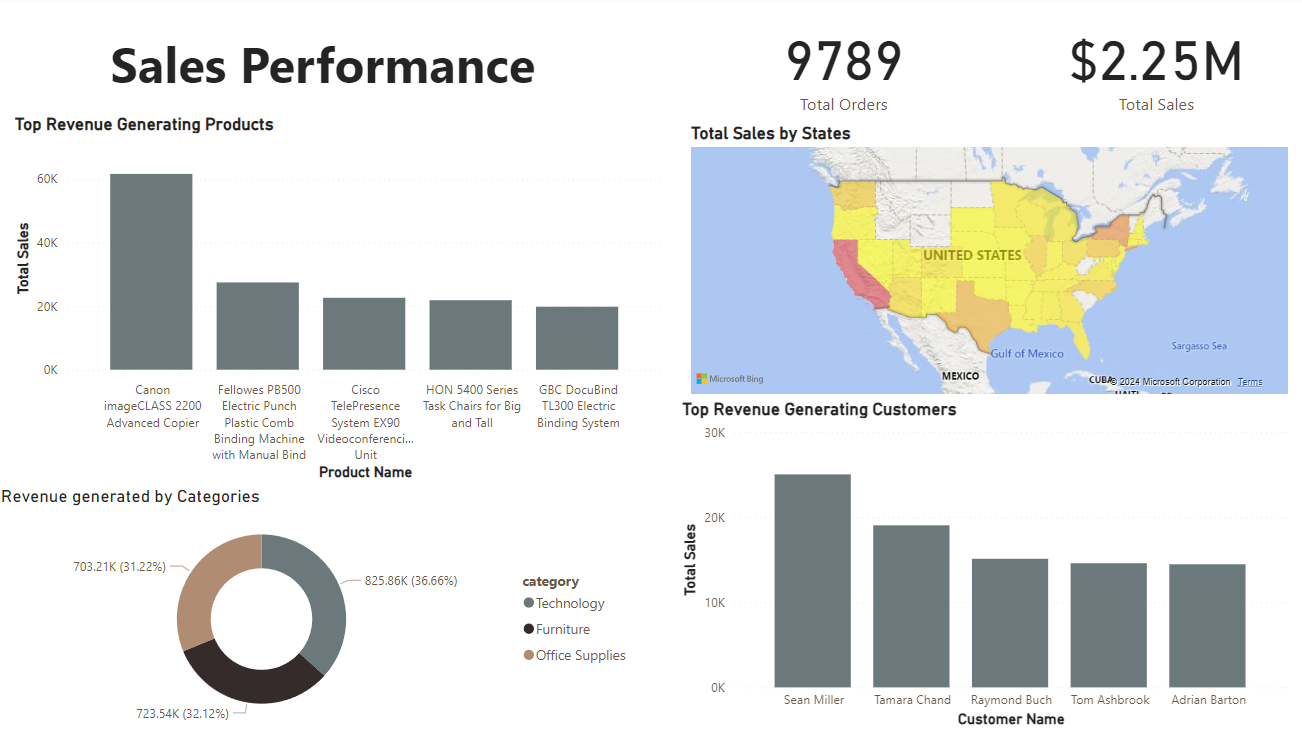<br><br>
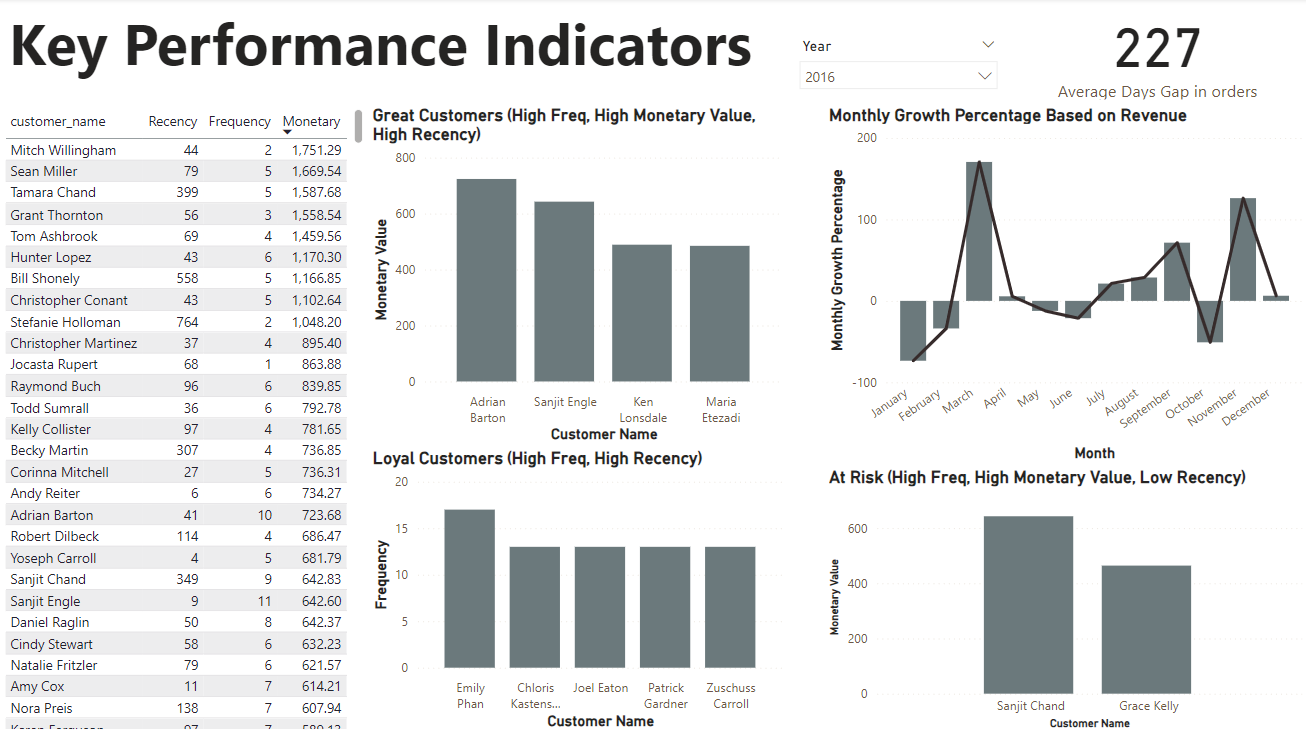<br><br>
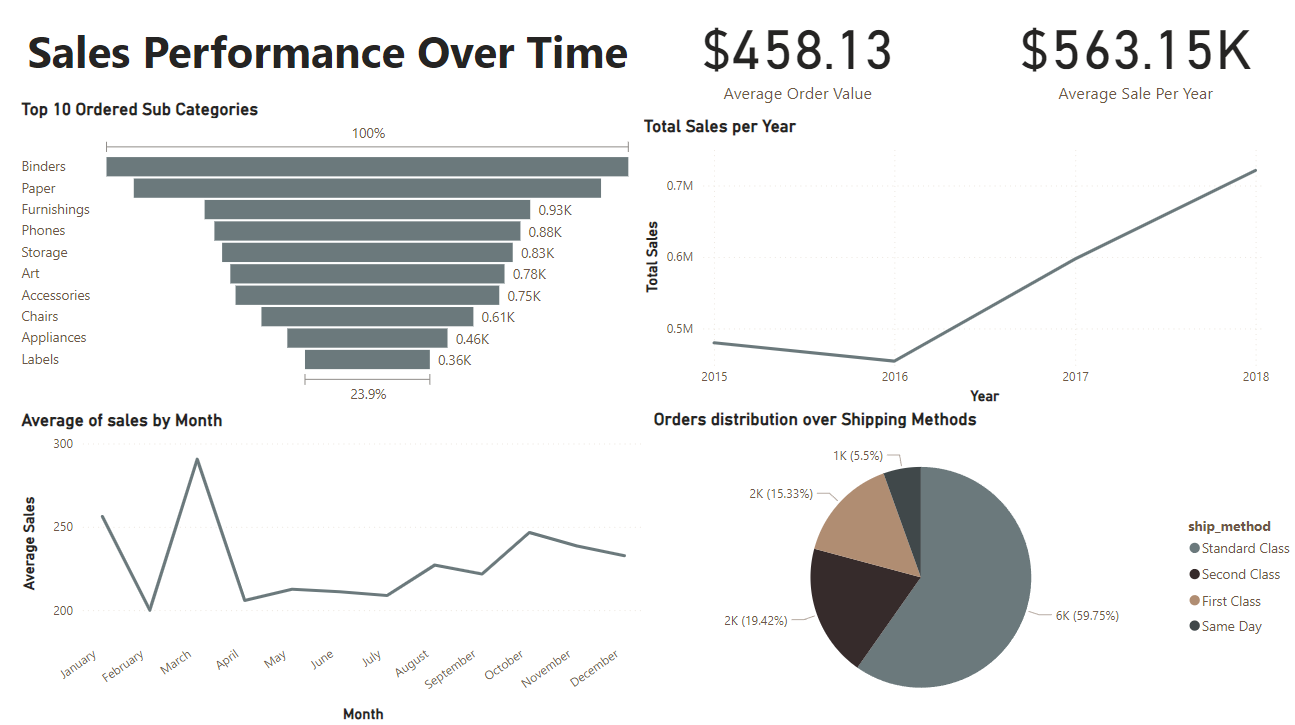